In [ ]:
from keras.models import Model

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten, LSTM, Input, Embedding,CuDNNLSTM, TimeDistributed
from keras.layers import BatchNormalization
# from keras.optimizers import Adam ,RMSprop
# from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.utils.np_utils import to_categorical


from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization , MaxPooling2D, Activation

In [ ]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 503.4 MB 31 kB/s 
     |████████████████████████████████| 438 kB 36.6 MB/s 
     |████████████████████████████████| 1.7 MB 43.1 MB/s 
     |████████████████████████████████| 5.8 MB 42.6 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, but you have tf-estimator-nightly 2.10.0.dev2022052508 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
X = pickle.load(open("/content/drive/MyDrive/MP sign language/Results/X.pkl", 'rb'))
Y = pickle.load(open("/content/drive/MyDrive/MP sign language/Results/Y.pkl", 'rb'))

In [ ]:
s = X.shape

In [ ]:
X = X.reshape(s[0], s[1], -1)
X.shape

(18540, 50, 126)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y)
Y_cat = to_categorical(integer_encoded)



In [ ]:
LR = 1e-2
inp = Input(shape = (X.shape[1], 126))
# inp = Input(batch_shape = (1, None, X.shape[2]))

lstm1 = LSTM(128, time_major=False, return_sequences = True)
lstmin =lstm1(inp)
lstm2 = LSTM(128, time_major=False)
lstmout = lstm2(lstmin)
# lstmout = LSTM(64, )(lstmout)
dense = Dense(Y_cat.shape[1] ,activation = "softmax")
out = dense(lstmout)
model = Model(inp, out)

In [ ]:
model.load_weights("/content/drive/MyDrive/MP sign language/Results/lstm_weights.best.hdf5")

In [ ]:
import tensorflow as tf
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 50
INPUT_SIZE = 126
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

MODEL_DIR = "/content/drive/MyDrive/MP sign language/Results/lstm_weights_fixed"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MP sign language/Results/lstm_weights_fixed/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MP sign language/Results/lstm_weights_fixed/assets


In [ ]:
with open('/content/drive/MyDrive/MP sign language/Results/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_,))
mapping

{0: 'Adult',
 1: 'Alright',
 2: 'Baby',
 3: 'Boy',
 4: 'Brother',
 5: 'Child',
 6: 'Crowd',
 7: 'Daughter',
 8: 'Family',
 9: 'Father',
 10: 'Friday',
 11: 'Friend',
 12: 'Girl',
 13: 'Grandfather',
 14: 'Grandmother',
 15: 'Hello',
 16: 'Husband',
 17: 'I',
 18: 'King',
 19: 'Man',
 20: 'Monday',
 21: 'Month',
 22: 'Mother',
 23: 'Neighbour',
 24: 'Parent',
 25: 'Player',
 26: 'Pleased',
 27: 'President',
 28: 'Queen',
 29: 'Saturday',
 30: 'Sister',
 31: 'Son',
 32: 'Sunday',
 33: 'Thursday',
 34: 'Today',
 35: 'Tomorrow',
 36: 'Tuesday',
 37: 'Wednesday',
 38: 'Week',
 39: 'Wife',
 40: 'Woman',
 41: 'Year',
 42: 'Yesterday',
 43: 'he',
 44: 'it',
 45: 'she',
 46: 'they',
 47: 'we',
 48: 'you'}

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.3 MB/s 


In [ ]:
import mediapipe as mp
import cv2
import time
 
ROOT = "/content/drive/MyDrive/MP sign language"

class handDetector():
    def __init__(self, mode=False, maxHands=2,modelC=0, detectionCon=0.5, trackCon=0.5):
        self.mode = mode
        self.maxHands = maxHands
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        self.modelC = modelC
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode, self.maxHands,self.modelC,
                                        self.detectionCon, self.trackCon)
        self.mpDraw = mp.solutions.drawing_utils
 
    def findHands(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(imgRGB)
        # print(self.results.multi_hand_landmarks)
        # print(len(self.results.multi_hand_landmarks))
        # if self.results.multi_hand_landmarks:
        #     for handLms in self.results.multi_hand_landmarks:
        #         # print("hand", handLms)
        #         if draw:
        #             self.mpDraw.draw_landmarks(img, handLms,)
        #                                       #  self.mpHands.HAND_CONNECTIONS)
                    
        return img,self.results.multi_hand_landmarks 
 
    def findPosition(self, img, handNo=0, draw=True):
 
        lmList = []
        if self.results.multi_hand_landmarks:
            myHand = self.results.multi_hand_landmarks[0]
            for id, lm in enumerate(myHand.landmark):
                # print(id, lm)
                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                # print(id, cx, cy)
                lmList.append([id, cx, cy])
                if draw:
                    cv2.circle(img, (cx, cy), 2, (255, 0, 0), cv2.FILLED)
            # myHand = self.results.multi_hand_landmarks[1]
            # for id, lm in enumerate(myHand.landmark):
            #     # print(id, lm)
            #     h, w, c = img.shape
            #     cx, cy = int(lm.x * w), int(lm.y * h)
            #     # print(id, cx, cy)
            #     lmList.append([id, cx, cy])
            #     if draw:
            #         cv2.circle(img, (cx, cy), 2, (0, 0, 255), cv2.FILLED)
 
        return lmList

Actual Word: Hello


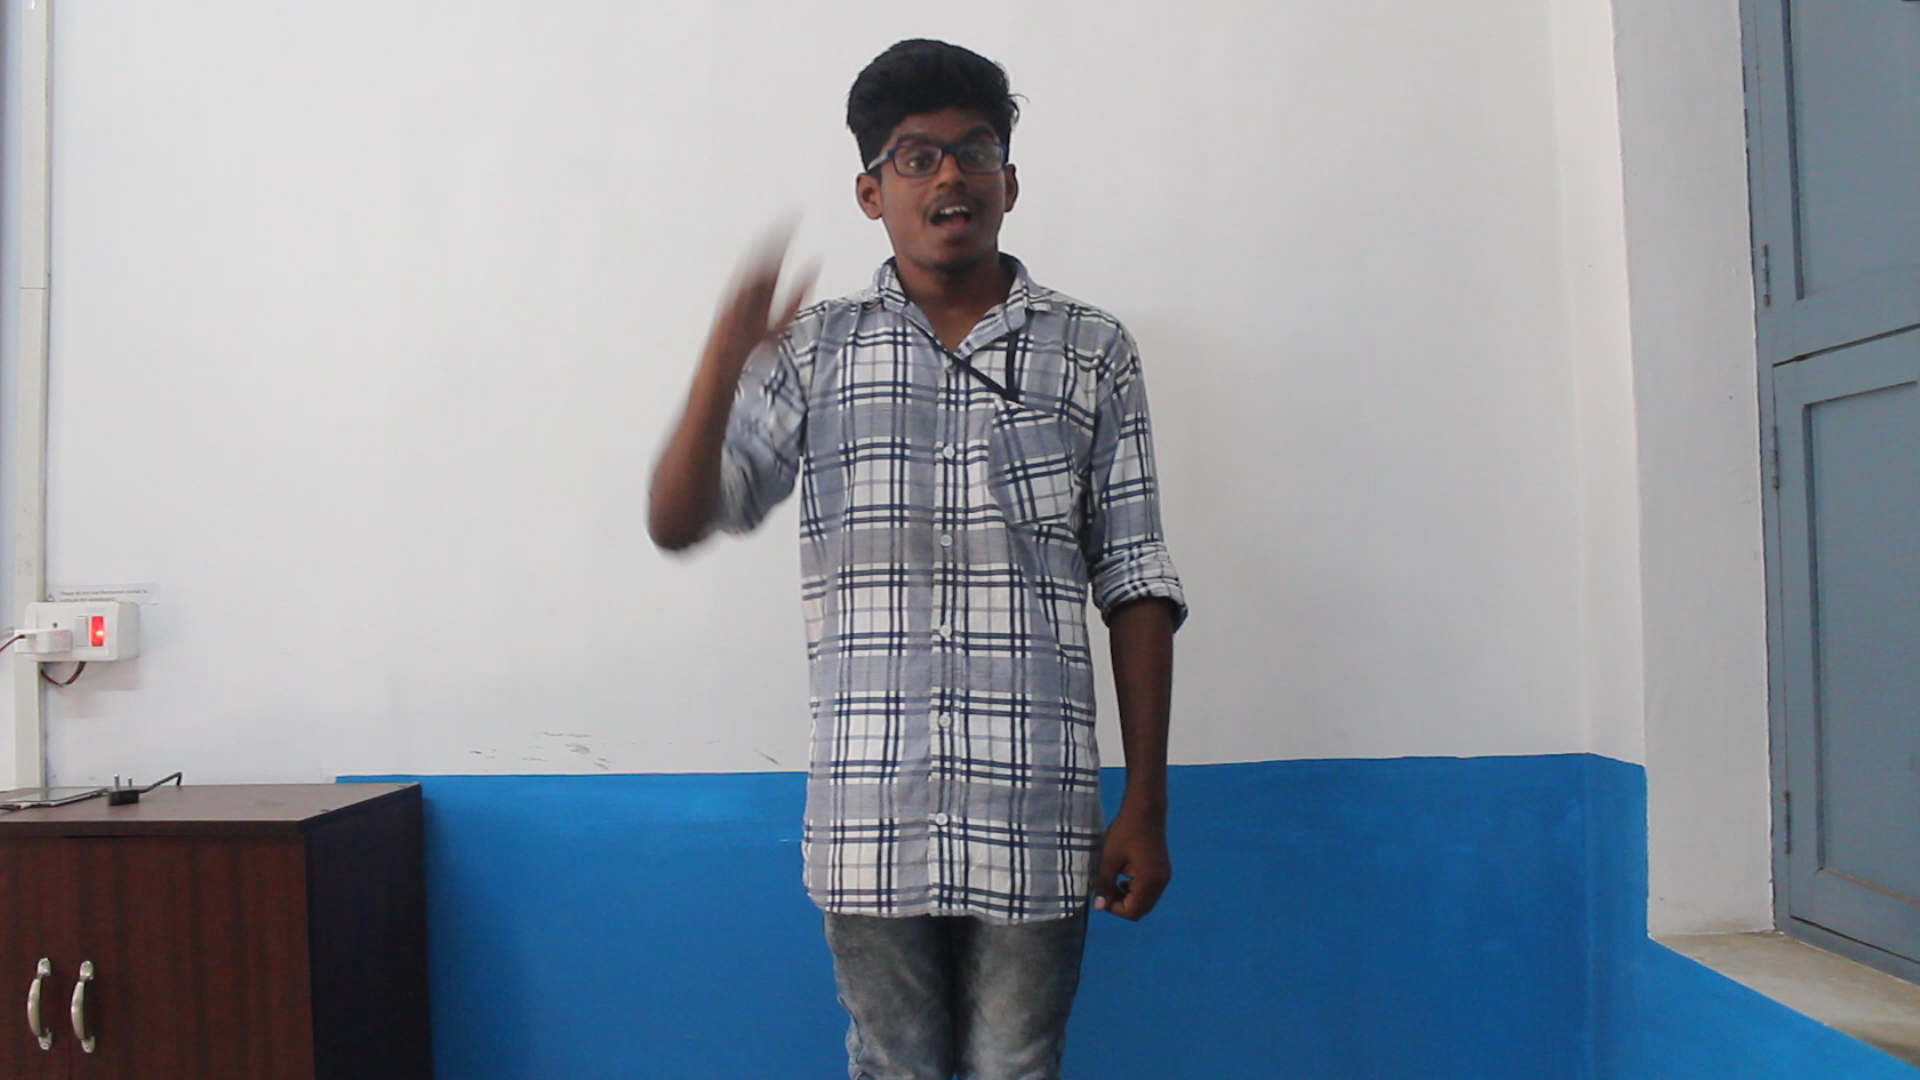

(1, 50, 42, 3)
Predicted : Hello 5.615530729293823


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import time, numpy as np
detector = handDetector()
vidcap = cv2.VideoCapture("/content/drive/MyDrive/MP sign language/ISL/Greetings/48. Hello/MVI_0030.MOV")
success,image = vidcap.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

count = 0
frames = []
start = time.time()
while success:
  # print("hi")
  # frames.append(image)   # save frame as JPEG file     
  image, lms = detector.findHands(image)
  if lms:
    hand_points = []
    for hands in lms:
      # keypoints= []
      for data_point in hands.landmark:
        hand_points.append([
              data_point.x,
              data_point.y,
              data_point.z,
              ])
      # hand_points.append(keypoints)
    if len(lms) == 1:
        temp_key = [[0,0,0]]*21
        # print("tempppppp: ",temp_key)
        hand_points = hand_points + temp_key
    # print(len(hand_points))
    frames.append(hand_points[:42])
    
  success,image = vidcap.read()
  if count==15:
    print("Actual Word: Hello")

    cv2_imshow(image)
    
  # print('Read a new frame: ', success)
  count += 1
for j in range(len(frames), X.shape[1]):
  frames.append(np.array([[0,0,0]]*42))
frames = np.expand_dims(np.array(frames[:50]), axis = 0)
print(frames.shape)
rng = frames.max(axis = 2).reshape(frames.shape[0], frames.shape[1], -1, frames.shape[3]) - frames.min(axis = 2).reshape(frames.shape[0], frames.shape[1], -1, frames.shape[3])
mini = frames.min(axis = 2).reshape(frames.shape[0], frames.shape[1], -1, frames.shape[3])
frames = (frames - mini)/rng
frames[np.isnan(frames)] = 0
# print(frames[0][0])
frames = frames.reshape(frames.shape[0], frames.shape[1], -1)


interpreter.set_tensor(input_details[0]["index"], frames.astype('float32'))
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]["index"])
# print(f"time taken : {time.time() - start}")
# print(f"Predicted : {mapping[np.argmax(tflite_model.predict(frames))]}", time.time() - start)

print(f"Predicted : {mapping[np.argmax(result)]}", time.time() - start)


In [ ]:
import numpy as np
class SentencePredictor:
  def __init__(self, interpreter, detector):
    self.interpreter = interpreter
    self.detector = detector
    self.predCount = 0
    self.currPred = ""
    self.isPred = False
    self.input_details = interpreter.get_input_details()
    self.output_details = interpreter.get_output_details()
    # self.frameCount = 0
    self.frames = []
  
  def predict(self, image):
    image, lms = self.detector.findHands(image)
    if lms:
      hand_points = []
      for hands in lms:
        # keypoints= []
        for data_point in hands.landmark:
          hand_points.append([
                data_point.x,
                data_point.y,
                data_point.z,
                ])
        # hand_points.append(keypoints)
      if len(lms) == 1:
          temp_key = [[0,0,0]]*21
          # print("tempppppp: ",temp_key)
          hand_points = hand_points + temp_key
      hand_points = np.array(hand_points)
      rng = hand_points.max(axis = 0).reshape(-1, hand_points.shape[1]) - hand_points.min(axis = 0).reshape(-1, hand_points.shape[1])
      mini = hand_points.min(axis = 0).reshape(-1, hand_points.shape[1])
      # print(rng.shape)
      hand_points = (hand_points - mini)/rng
      hand_points[np.isnan(hand_points)] = 0
      self.frames.append(hand_points)



      if len(self.frames) > 20:
        # print(len(self.frames))
        if len(self.frames) > 50:
          self.frames.pop(0)
        frames = list(self.frames)
        for j in range(len(frames), X.shape[1]):
          frames.append(np.array([[0,0,0]]*42))
        frames = np.array(frames)
        frames = np.expand_dims(frames, axis = 0)
        frames = frames.reshape(frames.shape[0], frames.shape[1], -1)
        interpreter.set_tensor(input_details[0]["index"], frames.astype('float32'))
        interpreter.invoke()
        pred = interpreter.get_tensor(output_details[0]["index"])
        # print(mapping[np.argmax(pred)], pred[0][np.argmax(pred)])

        # print(pred[0][np.argmax(pred)])
        # print(mapping[np.argmax(pred)])

        if self.isPred:
          if mapping[np.argmax(pred)] == self.currPred:
            self.predCount +=1
            if self.predCount >= 5:
              self.frames = [hand_points]
              self.isPred = False
              self.predCount = 0 
          else:
            self.frames = [hand_points]
            self.isPred = False
            self.predCount = 0

        else:
          if mapping[np.argmax(pred)] == self.currPred:
            self.predCount +=1

          elif pred[0][np.argmax(pred)] >= 0.8:
            self.currPred = mapping[np.argmax(pred)]
            self.predCount = 0

          if self.predCount == 15 and ~self.isPred:
            # print("Found")
            # print("*********************")
            # print(pred[0][np.argmax(pred)])
            print("Word Found:  ", mapping[np.argmax(pred)])
            # self.frames = []
            self.isPred = True
            # self.predCount = 0
            return mapping[np.argmax(pred)]
        # print("here")
        # print(pred[0][np.argmax(pred)])
        # print(mapping[np.argmax(pred)])
        
      # print()  


In [ ]:
import cv2

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

predictor = SentencePredictor(interpreter,handDetector())

vidList = [
           "/content/drive/MyDrive/MP sign language/ISL/Pronouns/40. I/MVI_9957.MOV",
           "/content/drive/MyDrive/MP sign language/ISL/Greetings/50. Alright/MVI_0043.MOV"
]
phrase = ""
start = time.time()
for vid in vidList:
  vidcap = cv2.VideoCapture(vid)
  success, image = vidcap.read()
  count = 0
  
  while success:
    # print(count)
    count += 1
    ret = predictor.predict(image)
    if ret != None:
      phrase += ret + " "
    success,image = vidcap.read()

# print("********************************************************")
# vidcap = cv2.VideoCapture("/content/drive/MyDrive/MP sign language/ISL/People/58. Son/MVI_5219.MOV")
# success, image = vidcap.read()
# while success:
#   print(count)
#   count += 1
#   ret = predictor.predict(image)
#   if ret != None:
#     phrase += ret + " "
#   success,image = vidcap.read()


print(f"The predicted wordset is :    {phrase}")
print(time.time() - start)

# para_phrases = parrot.augment(input_phrase=phrase, use_gpu=False)
# for para_phrase in para_phrases:
#   print("paraphrased sentence is:   ", para_phrase[0])
# frames = predictor.frames
# for j in range(len(frames), X.shape[1]):
#   frames.append(np.array([[0,0,0]]*42))
 
# frames = np.array(frames)
# frames = np.expand_dims(frames, axis = 0)
# frames = frames.reshape(frames.shape[0], frames.shape[1], -1)

# print(f"time taken : {time.time() - start}")
# print(f"prediction : {mapping[np.argmax(model.predict(frames))]}")

Word Found:   I
Word Found:   Alright
The predicted wordset is :    I Alright 
6.026198863983154
